Import thư viện

In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from Data_loader import FlickrDataset,get_data_loader
from CNN import CNN

In [11]:
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
data_location =  "./Flickr8k"
BATCH_SIZE = 256
# BATCH_SIZE = 6
NUM_WORKER = 4

transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])



dataset =  FlickrDataset(
    root_dir = data_location+"/Flicker8k_Dataset",
    caption_file = data_location+"./captions.txt",
    transform=transforms
)

data_loader = get_data_loader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
)

#vocab_size
vocab_size = len(dataset.vocab)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 0.003

In [42]:
state_dict = torch.load("./CNN.pth")
print(type(state_dict))

<class 'collections.OrderedDict'>


C:\Users\admin\AppData\Local\Temp\ipykernel_8884\4243783952.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./CNN.pth")


In [34]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        self.CNN = CNN()
        
        state_dict = torch.load("./CNN.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        self.CNN.load_state_dict(state_dict)

        for param in self.CNN.parameters():
            param.requires_grad_(False)
        
        modules = list(self.CNN.children())[:-2]
        self.CNN = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.CNN(images)                                    
        features = features.permute(0, 2, 3, 1)                           
        features = features.view(features.size(0), -1, features.size(-1)) 
        return features

C:\Users\admin\AppData\Local\Temp\ipykernel_8884\1533485398.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./CNN.pth", map_location=torch.devic

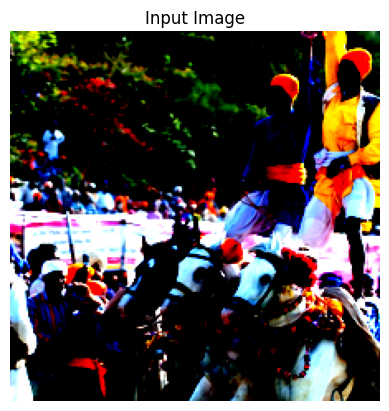

Extracted Features Shape: torch.Size([1, 50176, 3])
tensor([[[ 0.3823,  0.8179, -0.6541],
         [ 0.2624,  0.6779, -0.5321],
         [ 0.0741,  0.3803, -0.4450],
         ...,
         [-0.0801, -0.6352, -0.3230],
         [-0.1314, -0.9503, -0.6541],
         [-0.7650, -1.5280, -1.3513]]], device='cuda:0')


In [ ]:
# test encoder
# Lấy một ảnh từ tập dữ liệu Flickr8k
for idx, (image, captions) in enumerate(iter(data_loader)):
    # Chỉ lấy một ảnh và thoát khỏi vòng lặp
    image = image[0].unsqueeze(0)  # Chọn ảnh đầu tiên trong batch và thêm chiều batch
    captions = captions[0]  # Lấy caption tương ứng
    break

# Chuyển ảnh sang thiết bị GPU/CPU phù hợp
image = image.to(device)

# Tạo model EncoderCNN và chạy dự đoán
encoder = EncoderCNN().to(device)
features = encoder(image)

# Hiển thị ảnh và in kết quả đặc trưng
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Giải mã tensor ảnh về dạng numpy để hiển thị
image_np = image.cpu().squeeze(0).permute(1, 2, 0).numpy()
image_np = np.clip(image_np, 0, 1)  # Đảm bảo giá trị trong khoảng [0, 1]

# Hiển thị ảnh
plt.imshow(image_np)
plt.axis('off')
plt.title("Input Image")
plt.show()

# In đặc trưng (features)
print("Extracted Features Shape:", features.shape)
print(features)


In [35]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        # chuyển đổi chiều của encoder và decoder về cùng chiều với attention để tìm đặc trưng quan trọng đồng nhất
        self.attention_dim = attention_dim
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out) # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden) # (batch_size, attention_dim)
        att = torch.tanh(att1 + att2.unsqueeze(1)) # (batch_size, num_pixels, attention_dim)
        
        attention_scores = self.full_att(att) # (batch_size, num_pixels, 1)
        attention_scores = attention_scores.squeeze(2) # (batch_size, num_pixels)

        # hệ số của trọng số chú ý
        alpha = F.softmax(attention_scores, dim=1) # (batch_size, num_pixels) pixel càng quan trọng giá trị càng cao
        
        # trọng số chú ý
        attention_weights = encoder_out * alpha.unsqueeze(2) # (batch_size, num_pixels, encoder_out)
        attention_weights = attention_weights.sum(dim=1) # (batch_size, encoder_out)

        return alpha, attention_weights

In [36]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)

        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        embeds = self.embedding(captions)
        
        h, c = self.init_hidden_state(features)  
       
        seq_length = len(captions[0])-1 
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        
        
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [43]:
model = EncoderDecoder(embed_size=300,vocab_size = len(dataset.vocab),attention_dim=256,encoder_dim=2048,decoder_dim=512).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

C:\Users\admin\AppData\Local\Temp\ipykernel_8884\1533485398.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./CNN.pth", map_location=torch.devic

In [44]:
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'image_caption_model.pth')

In [40]:
num_epochs = 5
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(iter(data_loader)):
        image,captions = image.to(device),captions.to(device)

        optimizer.zero_grad()

        outputs,attentions = model(image, captions)

        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        loss.backward()

        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            # sinh chú thích
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader).to(device)
                img,_ = next(dataiter).to(device)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()
        
    save_model(model,epoch)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x3 and 2048x512)

In [45]:
# Tải state_dict từ tệp .pth
state_dict = torch.load("./CNN.pth")

# In thông tin về state_dict
for key, value in state_dict.items():
    print(f"Key: {key}, Shape: {value.size()}")

Key: neural_net.0.weight, Shape: torch.Size([32, 3, 3, 3])
Key: neural_net.0.bias, Shape: torch.Size([32])
Key: neural_net.2.weight, Shape: torch.Size([64, 32, 3, 3])
Key: neural_net.2.bias, Shape: torch.Size([64])
Key: neural_net.5.weight, Shape: torch.Size([128, 64, 3, 3])
Key: neural_net.5.bias, Shape: torch.Size([128])
Key: neural_net.7.weight, Shape: torch.Size([256, 128, 3, 3])
Key: neural_net.7.bias, Shape: torch.Size([256])
Key: neural_net.10.weight, Shape: torch.Size([512, 256, 3, 3])
Key: neural_net.10.bias, Shape: torch.Size([512])
Key: neural_net.12.weight, Shape: torch.Size([1024, 512, 3, 3])
Key: neural_net.12.bias, Shape: torch.Size([1024])
Key: neural_net.16.weight, Shape: torch.Size([1024, 16384])
Key: neural_net.16.bias, Shape: torch.Size([1024])
Key: neural_net.18.weight, Shape: torch.Size([512, 1024])
Key: neural_net.18.bias, Shape: torch.Size([512])
Key: neural_net.20.weight, Shape: torch.Size([10, 512])
Key: neural_net.20.bias, Shape: torch.Size([10])


C:\Users\admin\AppData\Local\Temp\ipykernel_8884\1448299573.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("./CNN.pth")
